# Calibration of the Optimal Steps Model

This script is an attempt to recompute the results in silver-2016b page 51. The scenario [scenario](./../../../../VadereModelTests/TestOSM_calibration/rimea_04_calibration_osm.scenario) is based on the RiMEA-Test 4. We use the `Teleporter` to model a circular scenario and the parameter `useFreeSpaceOnly = false` to generate high densities. The following code plots all the necessary diagrams.

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from vadere_analysis_tool import ScenarioOutput, VadereProject
from scipy.optimize import curve_fit

sns.set(style="whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.0})

def plotEvolution(vproject, ending, yval, ylabel):
    plots = []
    i = 1
    plt.figure(1, figsize=(30, 10))
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        dataFrames = []
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                #df = df[df.velocity > 0]
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['timeStep'] = df.timeStep.astype(int)
                ndf['scenario'] = [out.scenario['name']] * len(df.density)
                dataFrames.append(ndf)
            #concatFrames = pd.concat(dataFrames)
        plt.subplot(2, 1, i)
        plt.title(out.scenario['name'])
        plt.xlabel('timeStep')
        plt.ylabel(ylabel)
        sns.lineplot(x='timeStep', y=yval, data=pd.concat(dataFrames))
        i = i + 1

def plotFundamentalDiagram(vproject, ending):
    dataFrames = []
    for outStr in project.output_dirs :
        out = project.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                dataFrames.append(ndf)
    concatFrames = pd.concat(dataFrames)
    g = sns.relplot(x="density", y="velocity", hue="scenario", data=concatFrames,
                height=10, aspect=2)
    
def plotFundamentalDiagramScatter(vproject, ending, sep=False, width = 10, height = 5):
    dataFrames = []
    index = 0
    cols = 3
    rows = len(vproject.output_dirs) / cols + 1
    if not sep :
        fig, axs = plt.subplots(int(rows), int(cols), figsize=(height*rows, width*cols), sharex=False, sharey=True)       
    for outStr in vproject.output_dirs :
        out = vproject.output_dirs[outStr]
        for fileStr in out.files :
            if fileStr.endswith(ending) :
                if not sep : 
                    axes = axs[int(index / cols), int(index % cols)]
                else :
                    fig = plt.figure(1, figsize=(width, height))
                    axes = plt.axes()
                    fig.add_axes(axes)
                ndf = pd.DataFrame();
                df = out.files[fileStr]()
                ndf['density'] = df.density.astype(float)
                ndf['velocity'] = df.velocity.astype(float)
                ndf['scenario'] = [out.scenario['name']] * len(df.velocity)
                #ndf = ndf[ndf.density < 7]
                #plt.scatter()
                #axes.set_title(out.scenario['name'])
                axes.set_xlabel('density')
                axes.set_ylabel('velocity')
                axes.set_xticks([0,1,2,3,4,5,6])
                axes.set_yticks([0,0.5,1,1.5,2,2.5])
                axes.set_xlim(0,6)
                axes.set_ylim(0,2.5)
                axes.scatter(ndf['density'], ndf['velocity'], s=0.7, marker='*', color='#555555')
                wm = plotWeidmann(axes)
                popt, pcov = curve_fit(kladek, ndf['density'], ndf['velocity'], p0=(1.34, 1.913, 5.4))
                print(str(popt[0]) + "," + str(popt[1]) + "," + str(popt[2]))
                xx = np.linspace(0.1, 6, 1000)
                yy = kladek(xx, *popt)
                axes.plot(xx, yy, '--', c=sns.color_palette().as_hex()[1])     
                axes.legend(['Weidmann', 'regression', 'Simulated data'])
                index = index + 1;
                if sep :
                    fig.savefig("./"+out.scenario['name']+"_fundamental_diagram"+".png", bbox_inches='tight')
                    plt.show()
    if not sep :
        fig.savefig("./"+vproject.project_name+"_fundamental_diagrams"+".png", bbox_inches='tight')
        

In [7]:
def plotWeidmann(axes):
    wmaxDensity = 5.4
    wmeanVelocity = 1.34
    wgamma = 1.913
    wx = np.linspace(0.1, wmaxDensity, 100)
    return plotKladek(wx, wmeanVelocity, wgamma, wmaxDensity, axes)

def plotKladek(x, v, gamma, pmax, axes):
    result, = axes.plot(x, kladek(x, v, gamma, pmax), c=sns.color_palette().as_hex()[0])
    return result

def kladek(x, v, gamma, pmax):
    return v * (1 - np.exp(-gamma * (1/x - 1/pmax)))

First we load the project

In [8]:
projectFolder = "./../../../../VadereModelCalibration/TestOSM_calibration/"
project = VadereProject(projectFolder)
#out = project.named_output.C_050_180_180_2018_11_26_16_30_29_355()'

loaded 5 out of 5 output directories. 


# Meassurement methods
All methods are described in zhang-2011.

## Method A Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

In [872]:
# transform data frame
plotFundamentalDiagramScatter(project, "aTimeStep.fundamentalDiagram", True, 6, 6)

## Method B Plots
This method does not work for this scenario since agents run multiple times through the same measurement area.

## Method C Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

1.09598977853,2.60307653064,5.7172600023


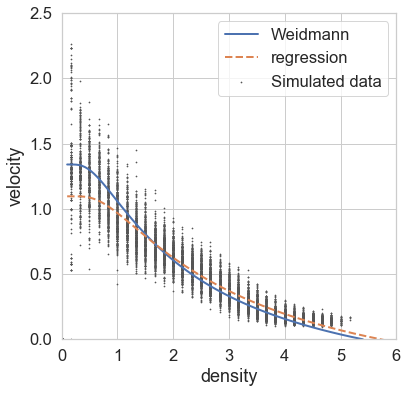

1.04365172849,2.77601030962,6.17771344067


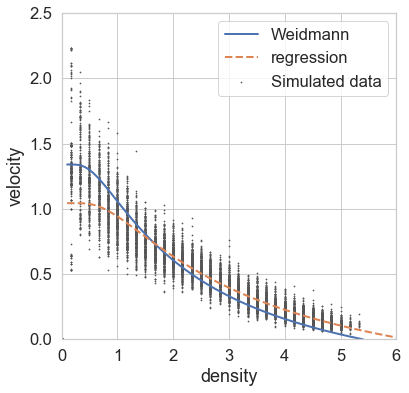

1.00950690582,4.0231057037,5.42205556099


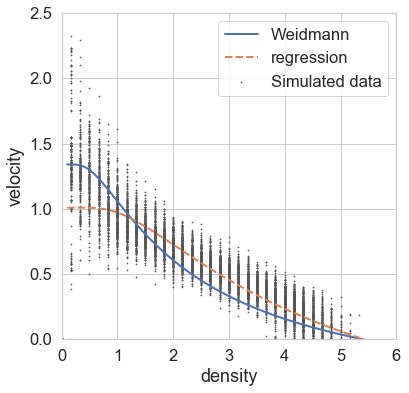

1.05243584192,2.9673646152,6.25808694348


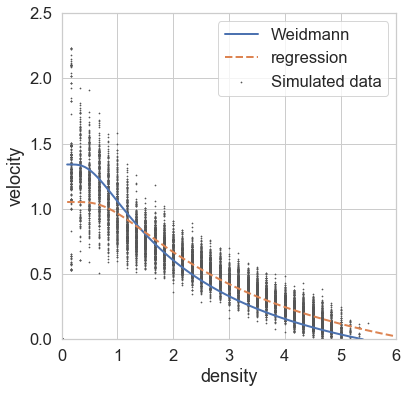

1.06095434794,4.32504288205,5.47219183859


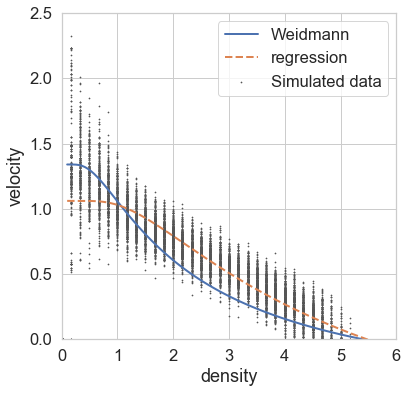

In [24]:
plotFundamentalDiagramScatter(project, "cTimeStep.fundamentalDiagram", True, 6, 6)

## Method D Plots
The computation of the velocity is slightly different i.e. we use the velocity computed by the current and last foot step.

1.31153677879,1.63591017016,6.31329791983


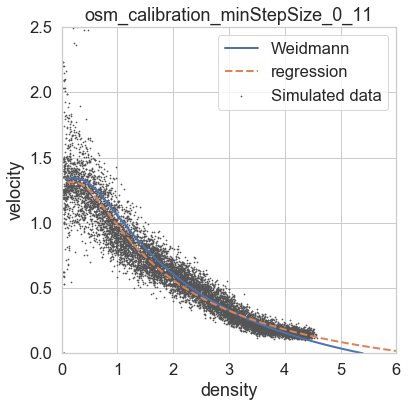

1.27929507782,1.61554754755,7.41274319187


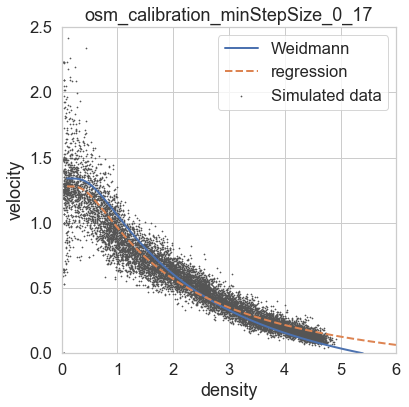

1.23002056156,2.22943029934,6.31005306265


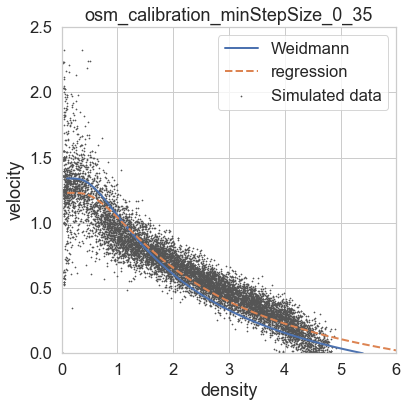

1.29467559573,1.6733716044,7.86471179297


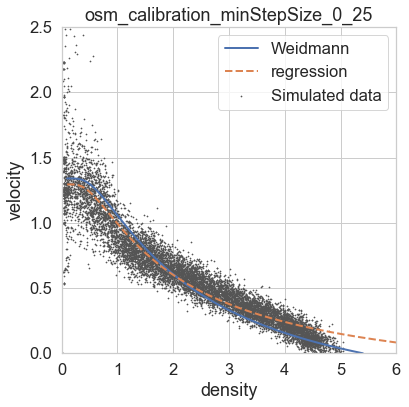

1.23583074427,2.72867755264,5.83620246417


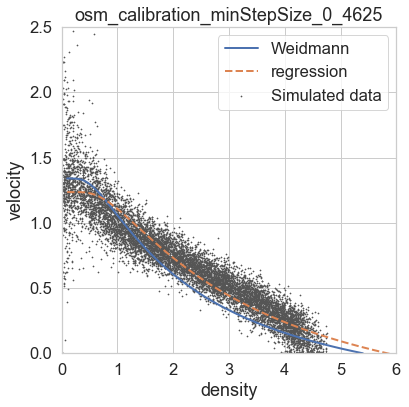

In [18]:
myPlots = plotFundamentalDiagramScatter(project, "dTimeStep.fundamentalDiagram", True, 6, 6)

## Method E Plots
This method is similar to method D but the density is defined by $$\langle \rho \rangle = \frac{1}{N} \sum\limits_{i=1}^{N} A_i ,$$
and the velocity is defined by 
$$\langle v \rangle = \sum\limits_{i=1}^{N} \frac{1}{A_i} \left( \sum\limits_{i=1}^{N} A_i v_i(t) \right) ,$$

where $N$ is the number of pedestrians inside the measurement area and $A_i$ is the area of the voronoi cell of agent $i$.

ValueError: array must not contain infs or NaNs

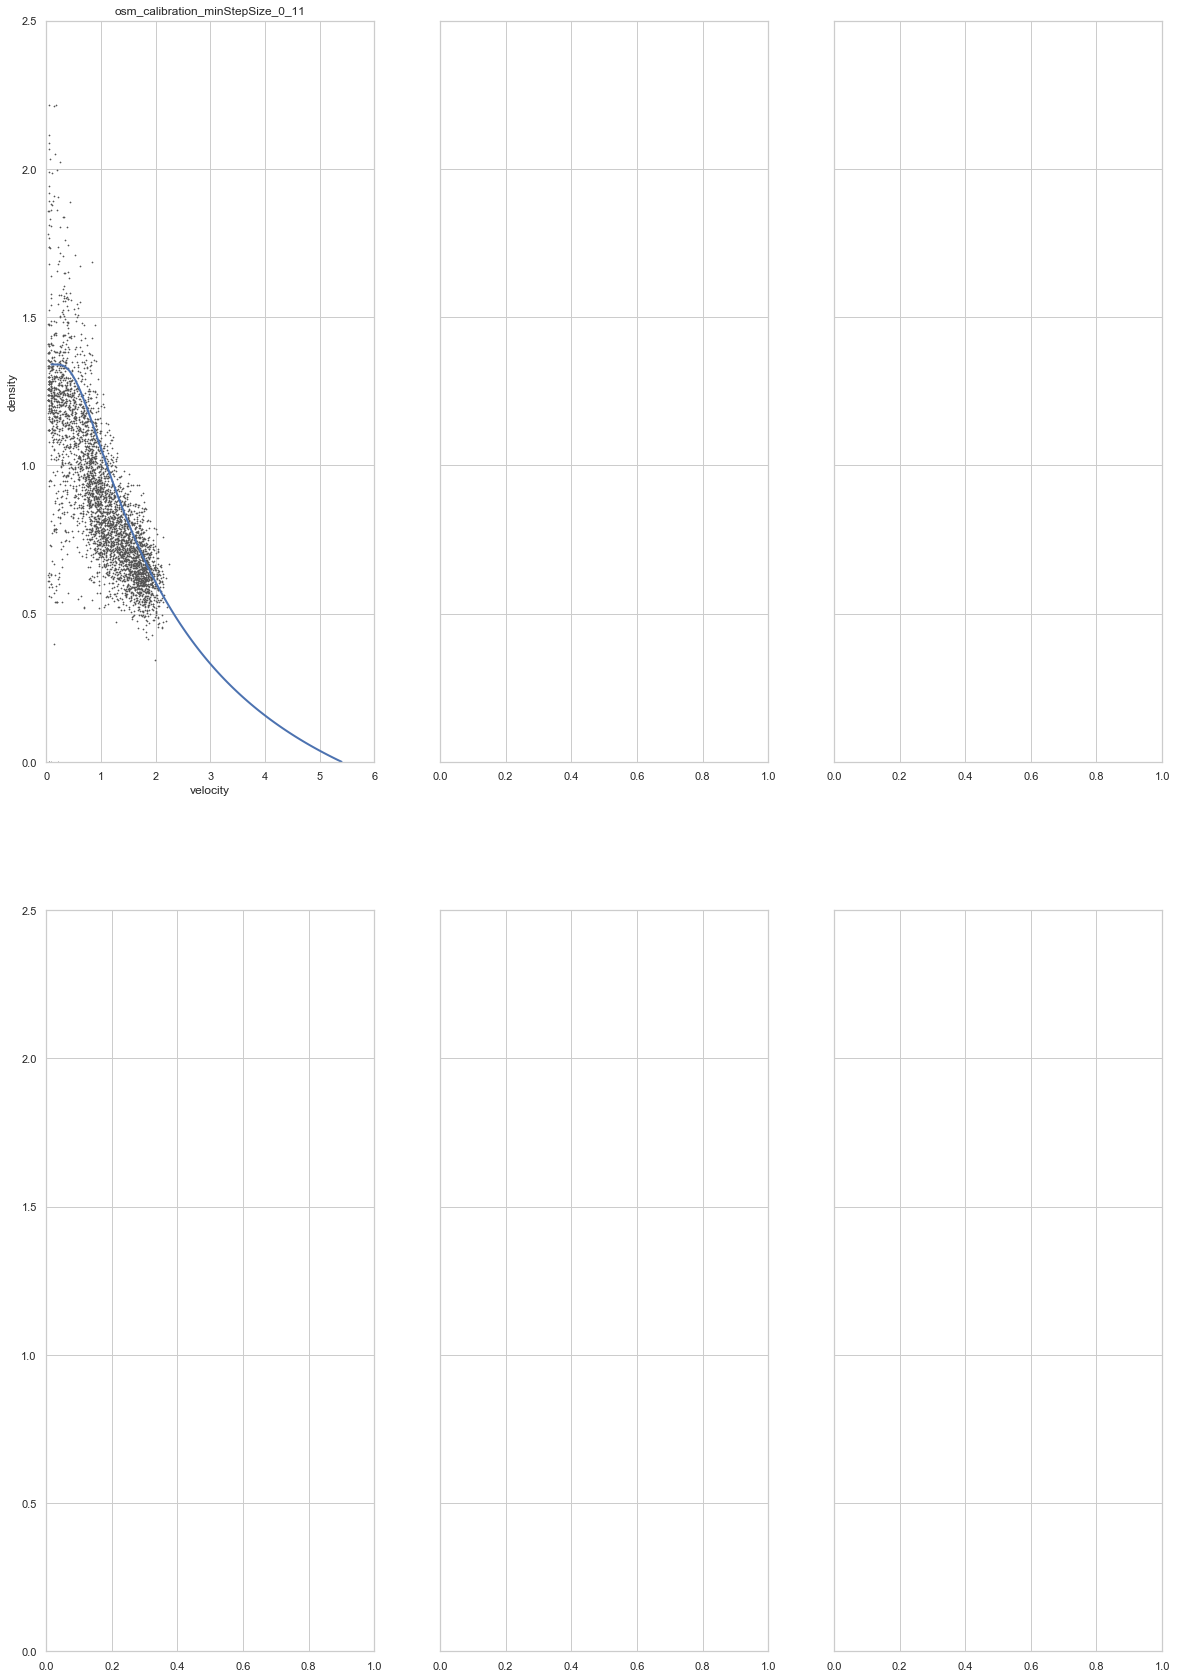

In [827]:
plotFundamentalDiagramScatter(project, "eTimeStep.fundamentalDiagram", False, 10, 10)

## Density and velocity evolution

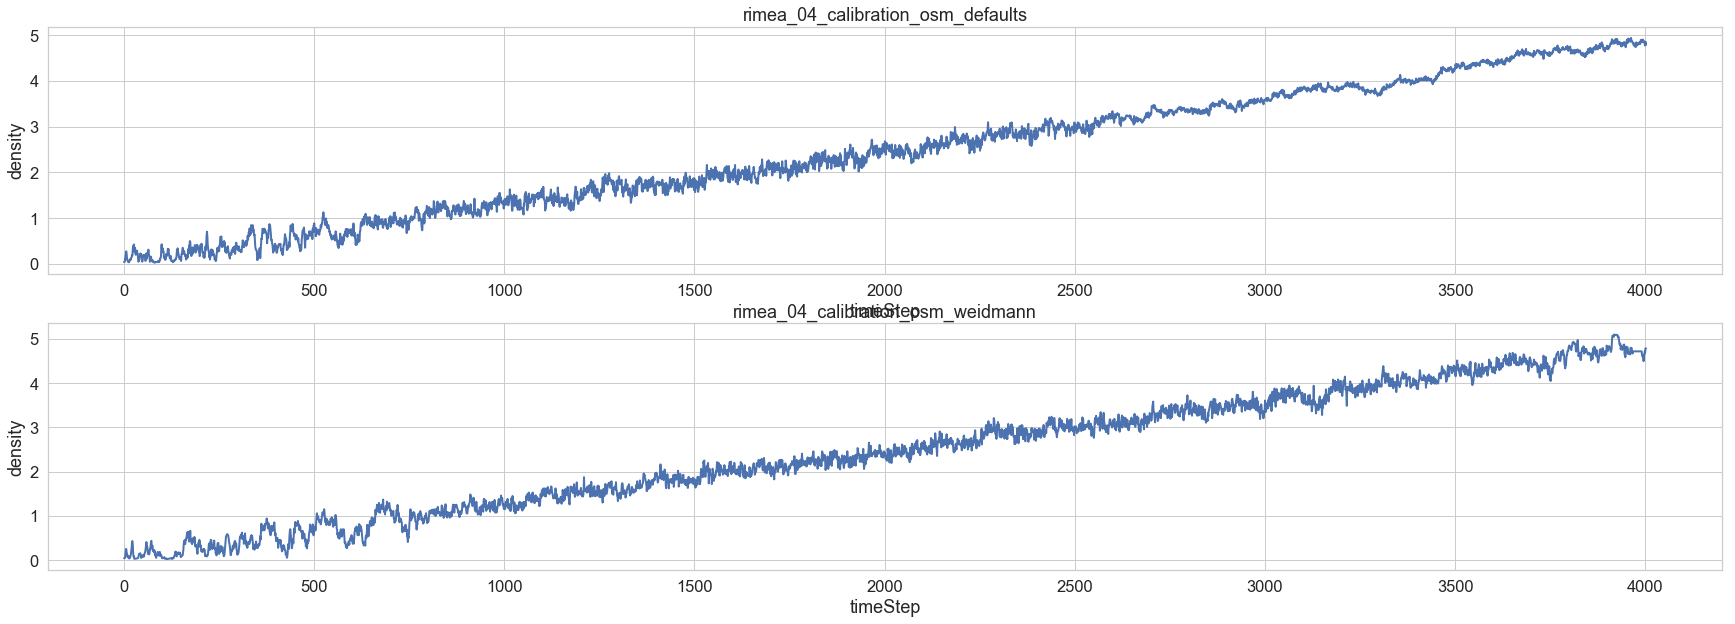

In [354]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "density", "density")
#plotEvolution(project, "aTimeStep.fundamentalDiagram", "density", "density")

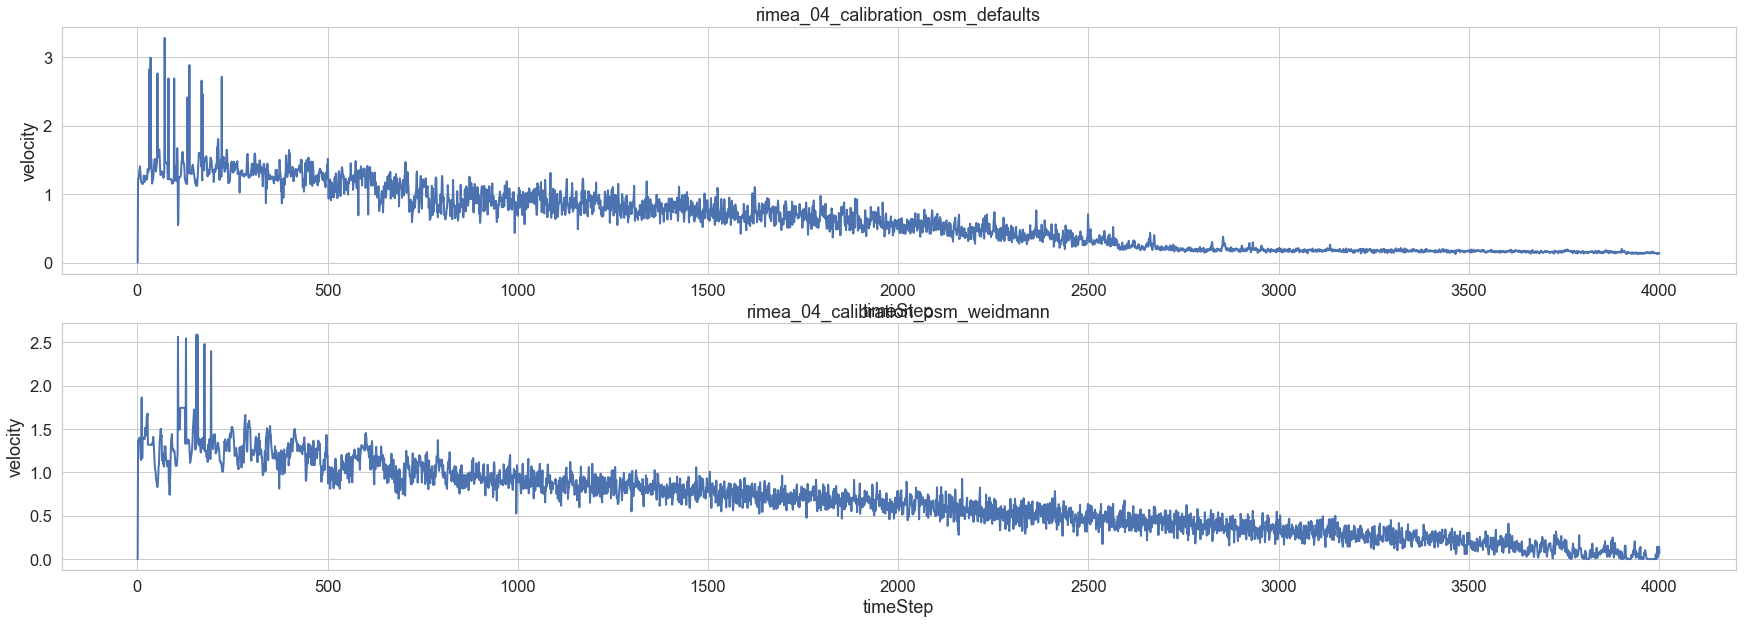

In [358]:
plotEvolution(project, "dTimeStep.fundamentalDiagram", "velocity", "velocity")

In [25]:
sns.color_palette()

[(0.29803921568627451, 0.44705882352941179, 0.69019607843137254),
 (0.8666666666666667, 0.51764705882352946, 0.32156862745098042),
 (0.33333333333333331, 0.6588235294117647, 0.40784313725490196),
 (0.7686274509803922, 0.30588235294117649, 0.32156862745098042),
 (0.50588235294117645, 0.44705882352941179, 0.70196078431372544),
 (0.57647058823529407, 0.47058823529411764, 0.37647058823529411),
 (0.85490196078431369, 0.54509803921568623, 0.76470588235294112),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.80000000000000004, 0.72549019607843135, 0.45490196078431372),
 (0.39215686274509803, 0.70980392156862748, 0.80392156862745101)]